##### Build a tree with tree69 with coalescent intervals distributed as Exp(klambda) and random lineages chosen at a coalescence

In [4]:
%matplotlib inline
import numpy as np
import random, math
from Node import Node
from Tree import Tree
import tree69

In [5]:
class TreeSimulation:
    def __init__(self):
        self.t = 0
        self.tree = None
        
    def tree_simulate(self, n, lamda):
        '''
        A method that simulates a tree based on the Yule model
        '''
        self.t = 0
        k = n
        self.tree = Tree()
        root = Node(label="root")
        
        # Initialize a node list, values do not matter at this stage
        node_list = [i for i in range(n)]
        for i in range(n):
            node_list[i] = Node(label=str(i+1))
            node_list[i].set_height(0)
            root.add_child(node_list[i])
        self.tree.set_root(root)
        
        # Branching process begins
        while k>1:
            t_k = -math.log(random.random())/(k*lamda)
            self.t+=t_k
            m = Node(label='m')
            m.set_height(self.t)
            
            # Randomly select two nodes from the list, w/o replacement
            children = random.sample(node_list,2)
            m.add_child(children[0])
            m.add_child(children[1])
            
            # Remove node i, j from the tree
            node_list.remove(children[0])
            node_list.remove(children[1])
            
            # Add node m to the tree
            node_list.append(m)
            root.add_child(m)
            root.remove_child(children[0])
            root.remove_child(children[1])
            k-=1
        self.tree.get_root().set_height(self.t)
        return self.tree
    
    def simulate_thousand_tree(self):
        result = 0
        for i in range(1000):
            result+=self.tree_simulate(10,0.5).get_root().get_height()
        return result/1000
    
    def plot(self):
        tree69.plot_tree(self.tree)
        
    def get_leaves(self):
        tree69.Tree.get_leaves(self.tree)

In [6]:
tree = TreeSimulation()

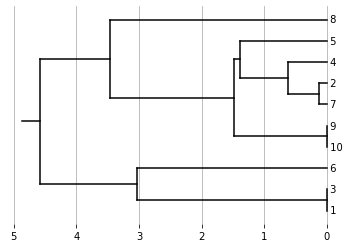

In [7]:
#The theoretical mean of 3.68 is agreed
tree = TreeSimulation()
tree.tree_simulate(10,0.5)
tree.plot()

#### Mutate down to all leaves recursively

In [8]:
# mutates a sequence according to the Jukes-Cantor model 
# X is an numpy.array with entries in {0,1,2,3}
# t is branch length 
# mu is mutation rate
#
def mutate(X,t,mu):
    '''
    A function to return the mutated sequence
    '''
    dna = ['A','G','C','T']
    import numpy.random as rand
    L= len(X)
    mutatedSeq = X.copy()
    numMutation = rand.poisson(L*mu*t)
    for i in range(numMutation):
        site = rand.randint(0,L)
        mutatedSeq[site] = dna[rand.randint(0,4)]
    return mutatedSeq

In [9]:
def traverse(node,mu):
    '''
    A helper function that recursively vist every node and assign the mutated seqeunce to its node
    '''

    dna = ['A','G','C','T']
    
    # If the node is valid
    if not None:
        # In this case, the tree is binary
        for child in node.get_children():
            
            # The branch length = height of current node - height of its child's node
            branch = node.get_height() - child.get_height()
            mutated_seq = mutate(node.get_sequence(),branch, mu)
            child.set_sequence(mutated_seq)
            traverse(child,mu)

In [10]:
def simulate_sequences(tree, L, mu):
    '''
    The main function that simulated sequences with given length and mutation rate
    '''
    dna = ['A','G','C','T']
    
    # Initialize a sequence uniformly generated to the root
    root_seq = [random.randint(0,3) for i in range(L)]
    tree.get_root().set_sequence([dna[item] for item in root_seq])
    traverse(tree.get_root(), mu)
    return tree

In [11]:
def get_sequences(tree):
    '''
    A function that returns a list contains all sequences of the leaves
    
    '''
    return [leaf.get_sequence() for leaf in tree.get_leaves()]

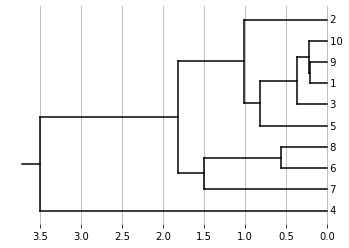

In [12]:
tree = TreeSimulation()
aTree = tree.tree_simulate(10,0.5)
simulate_sequences(aTree, 20, 0.5)
tree.plot()

In [13]:
###ADJUST seq needs to be stored at nodes

##### Calculate distance matrix for seqs from simulated tree 

In [15]:
def jc_distance(sequences):
    '''
    A function that calculates the Jukes-Cantor distance matrix from a set of sequences
    '''
    
    # Initialize a symmetric numpy array with dim = length of sequences
    d = np.zeros((len(sequences), len(sequences)))
    
    # Fill the value in the matrix
    for i in range(len(sequences)):
        for j in range(len(sequences)):
            d[i,j] = dxy(sequences[i], sequences[j])
    return d

In [16]:
def dxy(x,y):
    '''
    A function that calculates Jukes-Cantor distance by definition
    '''
    return -(3*math.log(1-4*fxy(x,y)/3))/4

In [17]:
def fxy(x,y):
    '''
    A function that calculates fraction of differing sites between x and y.
    '''
    
    # diff is the number of differing sites between x and y and L is the length of x.
    diff = 0
    for i in range(len(x)):
        if x[i]!=y[i]:
            diff+=1
    return min(diff/len(x), 0.75-1/len(x))

In [18]:
tree = TreeSimulation()
aTree = tree.tree_simulate(10,0.5)
simulate_sequences(aTree,20,0.5)
jc_distance(get_sequences(aTree))

array([[-0.        ,  0.47145649,  0.68721805,  0.99131688,  0.99131688,
         2.03103765,  2.03103765,  2.03103765,  2.03103765,  2.03103765],
       [ 0.47145649, -0.        ,  0.82395922,  1.51117727,  1.51117727,
         2.03103765,  2.03103765,  2.03103765,  2.03103765,  2.03103765],
       [ 0.68721805,  0.82395922, -0.        ,  1.51117727,  1.51117727,
         2.03103765,  1.20707843,  1.51117727,  1.20707843,  2.03103765],
       [ 0.99131688,  1.51117727,  1.51117727, -0.        , -0.        ,
         2.03103765,  2.03103765,  2.03103765,  2.03103765,  2.03103765],
       [ 0.99131688,  1.51117727,  1.51117727, -0.        , -0.        ,
         2.03103765,  2.03103765,  2.03103765,  2.03103765,  2.03103765],
       [ 2.03103765,  2.03103765,  2.03103765,  2.03103765,  2.03103765,
        -0.        ,  0.10732563,  0.05174465,  0.10732563,  2.03103765],
       [ 2.03103765,  2.03103765,  1.20707843,  2.03103765,  2.03103765,
         0.10732563, -0.        ,  0.05174465

##### Reconstruct trees with upgma

[[-0.          0.82395922  0.82395922  0.82395922  1.51117727  1.51117727
   1.51117727  1.20707843  1.20707843  1.51117727]
 [ 0.82395922 -0.         -0.         -0.          0.30409883  0.30409883
   0.30409883  0.47145649  0.30409883  0.38311922]
 [ 0.82395922 -0.         -0.         -0.          0.30409883  0.30409883
   0.30409883  0.47145649  0.30409883  0.38311922]
 [ 0.82395922 -0.         -0.         -0.          0.30409883  0.30409883
   0.30409883  0.47145649  0.30409883  0.38311922]
 [ 1.51117727  0.30409883  0.30409883  0.30409883 -0.         -0.
  -0.          0.30409883  0.30409883  0.38311922]
 [ 1.51117727  0.30409883  0.30409883  0.30409883 -0.         -0.
  -0.          0.30409883  0.30409883  0.38311922]
 [ 1.51117727  0.30409883  0.30409883  0.30409883 -0.         -0.
  -0.          0.30409883  0.30409883  0.38311922]
 [ 1.20707843  0.47145649  0.47145649  0.47145649  0.30409883  0.30409883
   0.30409883 -0.          0.47145649  0.57160504]
 [ 1.20707843  0.3040988

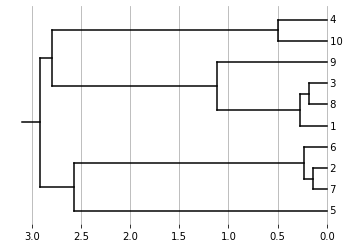

In [19]:
tree = TreeSimulation()
aTree = tree.tree_simulate(10,0.5)
simulate_sequences(aTree,20,0.1)
s = get_sequences(aTree)
tree.plot()
d = jc_distance(s)
print(d)
upgma_tree = tree69.compute_upgma_tree(d)